# ingest raw data

In [2]:
# settings
wkdir, s3dir = '/home/ubuntu/data/DL20181011_melanocyte_test_data', 'daniel.le-work/MEL_project'

%reload_ext autoreload
%autoreload 2
from scanpy_helpers_1 import *
from scanpy_helpers_2 import *
print ('scanpy version: {}'.format(sc.__version__))
warnings.filterwarnings('ignore')
%matplotlib inline

# read raw data (expression data) to pandas df
pre_adata = (pd.read_csv('s3://daniel.le-work/MEL_project/DL20190115_big_counts.txt', 
                      index_col=[0])
                .rename(columns = {'gene':'gene_name'})
                .set_index('gene_name'))
cell_names = ['_'.join(x.split('_')[:2]) for x in pre_adata.columns]
pre_adata.columns = cell_names

# read fetal supp data
pre_adata_supp1 = (pd.read_csv('s3://daniel.le-work/MEL_project/DL20190319_fetal_v2.csv')
                  .rename(columns = {'gene':'gene_name'})
                   .set_index('gene_name')
                  )

# read adult supp data
pre_adata_supp2 = (pd.read_csv('s3://daniel.le-work/MEL_project/DL20190417_adult_v2.csv')
                  .rename(columns = {'gene':'gene_name'})
                   .set_index('gene_name')
                  )

# merge with raw
pre_adata = pd.concat([pre_adata, pre_adata_supp1,pre_adata_supp2], axis=1)
cell_names = pre_adata.columns.tolist()

# metadata:
## download lastest from google drive and push to s3
meta_df = pd.read_csv('s3://daniel.le-work/MEL_project/DL20190417_mel_metadata.csv')
meta_df = meta_df.drop(['GWAS_consent', 
                        'sort_info_exported',
                       'sort_date',
                       'plate_order',
                       'sample_number',
                       'plate_status'], axis = 1)
possible_wells = [f'{y}{x}'for y in string.ascii_uppercase[:-10] for x in range(1,25)]
all_wells_df = pd.DataFrame()
for plate in meta_df.plate_barcode:
    well_df = pd.DataFrame({'well':possible_wells})
    well_df['plate_barcode'] = plate
    all_wells_df = pd.concat([all_wells_df, well_df], axis = 0)
    
meta_df = pd.merge(meta_df, all_wells_df, 'left', 'plate_barcode')
meta_df['cell_name'] = [f'{x}_{y}' for x,y in zip(meta_df.well, meta_df.plate_barcode)]

merged_anno = pd.merge(pd.DataFrame({'cell_name':cell_names}), meta_df, 'left', 'cell_name')
merged_anno = merged_anno.set_index('cell_name')


scanpy version: 1.3.3


In [3]:
def module_look_up(input_adata):
    MEL_module = ['PMEL','TYR','DCT','MITF','TYRP1','SOX10']
    bKRT_module = ['ITGB4','KRT14','KRT5']
    sbKRT_module = ['KRT1','DSG1','DSC3']
    T_cell = ['CD2','CD3D','CD3E','CD3G']
    B_cell = ['IGLL5','MZB1','JCHAIN','DERL3','SDC1','MS4A1','BANK1','PAX5','CD79A',
             'PRDM1','XBP1','IRF4','MS4A1','IRF8']
    langerhans_cell = ['CD207','CD1A'] # https://www.ncbi.nlm.nih.gov/pmc/articles/PMC351325/
    merkel_cell = ['KRT20','ATOH1']# https://www.ncbi.nlm.nih.gov/pubmed/7769257, http://dev.biologists.org/content/141/24/4690
    mast_cell = ['CMA1', 'MS4A2', 'TPSAB1', 'TPSB2']
    monocyte = ['PTPRC', 'CD14','FCGR3A'] #https://www.biolegend.com/essential_markers
    fibroblast = ['COL1A1','COL3A1','TWIST1'] # https://www.ncbi.nlm.nih.gov/pubmed/27113414
    eccrine_cell = ['FOXC1','RUNX1','S100P']

    # compile modules
    modules_dict = {'MEL_module':MEL_module,
                    'bKRT_module':bKRT_module,
                    'sbKRT_module':sbKRT_module,
                    'langerhans_cell':langerhans_cell,
                    'merkel_cell':merkel_cell,
                    'mast_cell':mast_cell, 
                    'T_cell':T_cell, 
                    'monocyte':monocyte, 
                    'fibroblast':fibroblast, 
                    'eccrine':eccrine_cell,
                   }

    input_adata.obs['cell'] = input_adata.obs.index.tolist()
    input_adata.obs['cell'] = (input_adata
                              .obs['cell']
                              .astype(str)
                              .astype(CategoricalDtype(input_adata.obs['cell'].tolist())))
    cat, exp_df = prepare_dataframe(input_adata,
                     var_names = [x for key,value in modules_dict.items() for x in value],
                     groupby = 'cell')
    exp_df = exp_df.rank(pct=True, axis=0, method = 'min') # ranked expression per cell
    exp_df = exp_df.rank(pct=True, axis=1, method = 'min') # ranking ranked expression per gene (normalizing contribution of each gene)

    for key,value in modules_dict.items():
        input_adata.obs[key] = exp_df.loc[:,value].mean(axis=1)
        sc.pl.umap(input_adata, color=[key], cmap = 'magma', palette = 'tab20')

    sc.pl.umap(input_adata, color=['louvain'], 
               ncols = 1, cmap = 'nipy_spectral', palette = 'tab20', legend_loc = 'on data')


# compile raw data

In [4]:
raw_adata = create_adata(pre_adata)
raw_adata.var['ribo'] = raw_adata.var_names.str.startswith(('RPL','RPS'))
raw_adata.var['ercc'] = np.array([True if 'ERCC' in x else False for x in raw_adata.var_names.tolist()])
sc.pp.calculate_qc_metrics(raw_adata, feature_controls=['ribo','ercc'], inplace=True)
anno_dict = {'age':'age',
             'age_bin':'age_bin',
             'plate_barcode':'plate',
             'general_location':'general_location',
             'anatomical_location':'anatomical_location',
             'race':'race',
             'sex':'sex',
             'sample_color':'color',
             'patient_id':'patient'}
append_anno(raw_adata, merged_anno, anno_dict)
technical_filters(raw_adata)
raw_adata = remove_ercc(raw_adata) 
raw_adata.raw = sc.pp.log1p(raw_adata, copy=True) # freeze raw state

Ingest raw data...
	Cells: 14370, Genes: 26577
Append annotations...
	Cells: 14370, Genes: 26577
Remove low-quality cells/genes...
	Initial:
	Cells: 14370, Genes: 26577
	Result:
	Cells: 10421, Genes: 24661
Remove ERCC genes...
Filtered genes: 89
	Cells: 10421, Genes: 24572


# append metadata to raw adata

## cycling cells
ref: https://www.biorxiv.org/content/biorxiv/early/2019/02/03/526848.full.pdf 
high = G2/M, low = G1/S

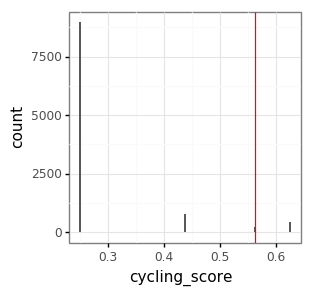

<ggplot: (-9223363299890704191)>

In [5]:
cycling_module = ['TOP2A','CDK1','UBE2C','CDT1']
input_adata = raw_adata
threshold = 95

input_adata.obs['cell'] = input_adata.obs.index.tolist()
input_adata.obs['cell'] = (input_adata
                          .obs['cell']
                          .astype(str)
                          .astype(CategoricalDtype(input_adata.obs['cell'].tolist())))
cat, exp_df = prepare_dataframe(input_adata,
                 var_names = cycling_module,
                 groupby = 'cell')
exp_df = exp_df.rank(pct=True, axis=0, method = 'min') # ranked expression per cell
exp_df = exp_df.rank(pct=True, axis=1, method = 'min') # ranking ranked expression per gene

input_adata.obs['cycling_score'] = exp_df.loc[:,cycling_module].mean(axis=1)
omit_names = (input_adata[input_adata.obs.cycling_score > np.percentile(input_adata.obs.cycling_score.values, threshold)]
              .obs
              .index
              .tolist()
             )

input_adata.obs['cycling_cell'] = ['G2_M' if x in set(omit_names) else 'G1_S' for x in input_adata.obs.index]

cycling_df = input_adata.obs.loc[:,['n_genes','cycling_score']]

plotnine.options.figure_size = (3,3)
plot_df = (ggplot(cycling_df)
           + theme_bw()
           + geom_histogram(aes('cycling_score'))
           + geom_vline(aes(xintercept = np.percentile(input_adata.obs.cycling_score.values, threshold)), color = 'red')
          )
plot_df


## back-scatter

In [6]:
bucket = 'daniel.le-work'
prefix = 'MEL_project/facs_data'
suffix = '.csv'
paths = get_s3path_list(bucket, prefix, suffix)

master_bsc = pd.DataFrame()
for path in paths:
    pathoi = path
    pathoi_plate = pathoi.split('/')[-1].split('_')[0].split('-')[0]
    tmpdf = pd.read_csv(pathoi).loc[:,['BSC-A','Index']]
    tmpdf['plate'] = pathoi_plate
    
    master_bsc = master_bsc.append(tmpdf)
    
master_bsc['code'] = [f'{x}_{y}' for x,y in zip(master_bsc.Index, master_bsc.plate)]
master_bsc = master_bsc.drop_duplicates(subset=['code'])
# append results
# join bsc to adata index order
for input_adata in [raw_adata]:
    mergedf = pd.merge(pd.DataFrame({'code':input_adata.obs.index.values}), master_bsc.loc[:,['BSC-A','code']], 'left', 'code')
    mergedf['plate'] = [x.split('_')[-1] for x in mergedf.code]
    mergedf['well'] = [x.split('_')[0] for x in mergedf.code]
    mergedf['pass'] = np.isnan(mergedf['BSC-A'])
    input_adata.obs['bsc'] = mergedf['BSC-A'].values
    

## FACS gates

In [7]:
input_adata = raw_adata

gate_labels = pd.read_csv('s3://daniel.le-work/MEL_project/gate_assignments.csv', index_col = 0)
gate_labels.columns = [x.split('-')[0] for x in gate_labels.columns]
gate_labels = (gate_labels
               .iloc[:, [idx for idx,x in enumerate(gate_labels
                                                    .columns
                                                    .duplicated(keep='first')) if x == False]]
                )
gate_labels = pd.melt(gate_labels.reset_index(), id_vars='index')
gate_labels['cell_id'] = [f'{y}_{x}' for x,y in zip(gate_labels['variable'], gate_labels['index'])]
gate_labels = pd.merge(pd.DataFrame({'cell_id':input_adata.obs.index}),
                       gate_labels.loc[:,['cell_id','value']],
                       'left',
                       'cell_id'
                      )

input_adata.obs['gate_label'] = gate_labels['value'].values
input_adata.obs['gate_label'] = input_adata.obs['gate_label'].replace(np.nan, 'null')
input_adata.obs['gate_label'] = (input_adata.obs['gate_label']
                                 .astype(str)
                                 .astype(CategoricalDtype(['a6high', 'a6mid', 'a6low', 'ckitpos', 'null'],ordered=True))
                                )


# Filters

## initial clustering

... storing 'age_bin' as categorical
... storing 'plate' as categorical
... storing 'general_location' as categorical
... storing 'anatomical_location' as categorical
... storing 'race' as categorical
... storing 'sex' as categorical
... storing 'color' as categorical
... storing 'patient' as categorical
... storing 'cycling_cell' as categorical


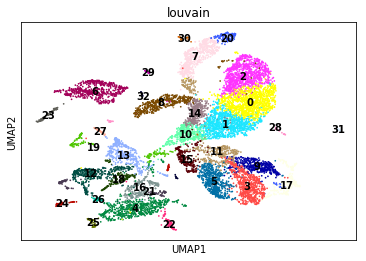

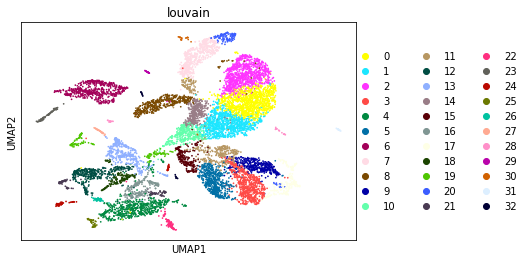

In [8]:
n_pcs = 75

all_cells_adata = sc.pp.log1p(raw_adata, copy=True) # new
sc.pp.highly_variable_genes(all_cells_adata,min_mean=0.1,max_mean=10,min_disp=0.5) # new
sc.pp.scale(all_cells_adata) # new
sc.tl.pca(all_cells_adata, use_highly_variable = True, n_comps=n_pcs) # new
sc.pp.neighbors(all_cells_adata, n_pcs=n_pcs, n_neighbors = 6) # new
sc.tl.umap(all_cells_adata, min_dist = 0.5)
sc.tl.louvain(all_cells_adata, resolution = 1)
sc.pl.umap(all_cells_adata, color=['louvain'], legend_loc='on data')
sc.pl.umap(all_cells_adata, color=['louvain'])


## decontamination_1
32 = single plate, well series
31 = single plate, well series
30 = multi plate, well series
28 (I13-22_B003580) = multi plate, well series

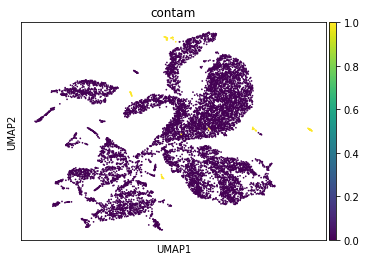

In [9]:
# compile contaminations
contam_32 = all_cells_adata.obs[all_cells_adata.obs.louvain == '32'].index.tolist()
contam_31 = all_cells_adata.obs[all_cells_adata.obs.louvain == '31'].index.tolist()
contam_30 = all_cells_adata.obs[all_cells_adata.obs.louvain == '30'].index.tolist()
manual_contam_1 = [f'I{x}_B003580' for x in range(13,23)] # cluster 28

full_contam = contam_32+contam_31+contam_30+manual_contam_1

# classify in all_cells_adata
input_adata = all_cells_adata
input_adata.obs['contam'] = [x in full_contam for x in input_adata.obs.index]
sc.pl.umap(input_adata, color = 'contam')

# classify in raw_adata
raw_adata.obs['contam'] = [x in full_contam for x in raw_adata.obs.index]


... storing 'age_bin' as categorical
... storing 'plate' as categorical
... storing 'general_location' as categorical
... storing 'anatomical_location' as categorical
... storing 'race' as categorical
... storing 'sex' as categorical
... storing 'color' as categorical
... storing 'patient' as categorical
... storing 'cycling_cell' as categorical


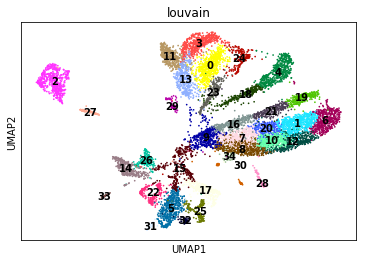

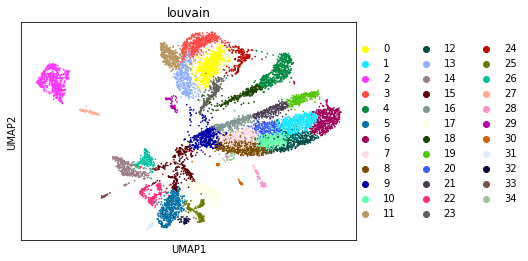

In [10]:
decontam_adata = raw_adata[raw_adata.obs['contam'] == False]
decontam_adata = sc.pp.log1p(decontam_adata, copy=True) # new
sc.pp.highly_variable_genes(decontam_adata,min_mean=0.1,max_mean=10,min_disp=0.5) # new
sc.pp.scale(decontam_adata) # new
sc.tl.pca(decontam_adata, use_highly_variable = True, n_comps=n_pcs) # new
sc.pp.neighbors(decontam_adata, n_pcs=n_pcs, n_neighbors=25) # new
sc.tl.umap(decontam_adata, min_dist = 0.5)
sc.tl.louvain(decontam_adata, resolution = 3)
sc.pl.umap(decontam_adata, color=['louvain'], legend_loc='on data')
sc.pl.umap(decontam_adata, color=['louvain'])


## low-quality and doublet filter
15 = low-quality (low n_genes)
31 = doublet (co-expression of PMEL and KRT1/KRT15)

n_genes                                                            \
       count         mean          std     min     25%     50%     75%   
coi                                                                      
15     333.0  1308.708709   678.240430   502.0   794.0  1138.0  1599.0   
31      45.0  8632.711111  1584.599499  4727.0  8122.0  8899.0  9624.0   
rest  9977.0  3286.010524  1351.911183   510.0  2224.0  3230.0  4207.0   

               
          max  
coi            
15     3660.0  
31    11491.0  
rest  16354.0

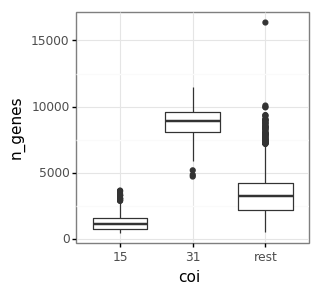

<ggplot: (-9223363299888455729)>

In [11]:
# n_genes of filtered cells
input_adata = decontam_adata
ngene_df = input_adata.obs.loc[:,['louvain','n_genes']]
ngene_df['coi'] = [x if x in ['15','31'] else 'rest' for x in ngene_df.louvain]
display(ngene_df.groupby('coi').describe())

plotnine.options.figure_size = (3,3)
plot = (ggplot(ngene_df)
        + theme_bw()
        + geom_boxplot(aes('coi','n_genes'))
       )
plot


... storing 'coi' as categorical


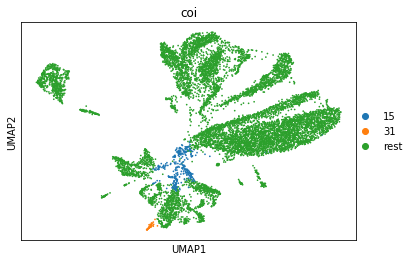

In [12]:
# compile contaminations
contam_15 = decontam_adata.obs[decontam_adata.obs.louvain == '15'].index.tolist()
contam_31 = decontam_adata.obs[decontam_adata.obs.louvain == '31'].index.tolist()


full_contam = full_contam + contam_15 + contam_31
full_contam = list(set(full_contam))

# classify in full_adata
input_adata = decontam_adata
input_adata.obs['contam'] = [x in full_contam for x in input_adata.obs.index]
input_adata.obs['coi'] = [x if x in ['15','31'] else 'rest' for x in input_adata.obs.louvain]
sc.pl.umap(input_adata, color = 'coi')

# classify in raw_adata
raw_adata.obs['contam'] = [x in full_contam for x in raw_adata.obs.index]


... storing 'age_bin' as categorical
... storing 'plate' as categorical
... storing 'general_location' as categorical
... storing 'anatomical_location' as categorical
... storing 'race' as categorical
... storing 'sex' as categorical
... storing 'color' as categorical
... storing 'patient' as categorical
... storing 'cycling_cell' as categorical


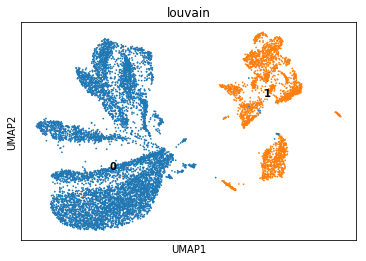

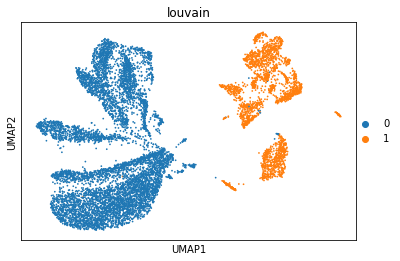

In [13]:
full_adata = raw_adata[raw_adata.obs['contam'] == False]
full_adata = sc.pp.log1p(full_adata, copy=True) # new
sc.pp.highly_variable_genes(full_adata,min_mean=0.1,max_mean=10,min_disp=0.5) # new
sc.pp.scale(full_adata) # new
sc.tl.pca(full_adata, use_highly_variable = True, n_comps=n_pcs) # new
sc.pp.neighbors(full_adata, n_pcs=n_pcs, n_neighbors=65) # new
sc.tl.umap(full_adata, min_dist = 0.5)
sc.tl.louvain(full_adata, resolution = 0.02)
sc.pl.umap(full_adata, color=['louvain'], legend_loc='on data')
sc.pl.umap(full_adata, color=['louvain'])


# iterative re-clustering

## cluster_0

... storing 'age_bin' as categorical
... storing 'plate' as categorical
... storing 'general_location' as categorical
... storing 'anatomical_location' as categorical
... storing 'race' as categorical
... storing 'sex' as categorical
... storing 'color' as categorical
... storing 'patient' as categorical
... storing 'cycling_cell' as categorical


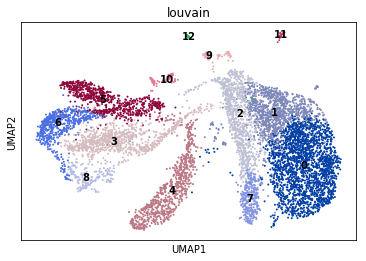

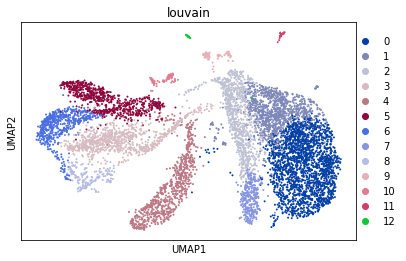

In [14]:
coi = full_adata[full_adata.obs.louvain == '0'].obs.index.tolist()
raw_adata.obs['recluster'] = [x in coi for x in raw_adata.obs.index]
recluster_0 = raw_adata[raw_adata.obs['recluster'] == True]
recluster_0 = sc.pp.log1p(recluster_0, copy=True) # new
sc.pp.highly_variable_genes(recluster_0,min_mean=0.1,max_mean=10,min_disp=0.5) # new
sc.pp.scale(recluster_0) # new
sc.tl.pca(recluster_0, use_highly_variable = True, n_comps=n_pcs) # new
sc.pp.neighbors(recluster_0, n_pcs=n_pcs, n_neighbors=10) # new
sc.tl.umap(recluster_0, min_dist = 0.5)
sc.tl.louvain(recluster_0, resolution = 0.45)
sc.pl.umap(recluster_0, color=['louvain'], legend_loc='on data')
sc.pl.umap(recluster_0, color=['louvain'])


In [15]:
# ## well series test
# cluster = '9'
# input_adata = recluster_0
# well_series_test(cluster, input_adata)
# input_adata.obs['coi'] = [x == cluster for x in input_adata.obs.louvain]
# print(set(input_adata.obs[input_adata.obs['coi'] == True].patient))
# sc.pl.umap(input_adata, color = ['coi','PMEL','KRT1','KRT15','n_genes','age'], ncols = 2
#           )

# sc.tl.rank_genes_groups(input_adata, groupby='louvain', groups=[cluster], method='wilcoxon',reference='rest')
# gene = [x[0] for x in input_adata.uns['rank_genes_groups']['names']]
# out = symbol2field(gene[:gene_n])
# output = [print(f'{idx}: ', 
#        x['query'],
#        '\n',x['summary']) if ('summary' in x.keys()) else print(f'{idx}: ', 
#                                                                 x['query'],
#                                                                 '\n','N/A') for idx, x in enumerate(out)]




In [16]:
# module look up
# module_look_up(recluster_0)

... storing 'named_cluster' as categorical


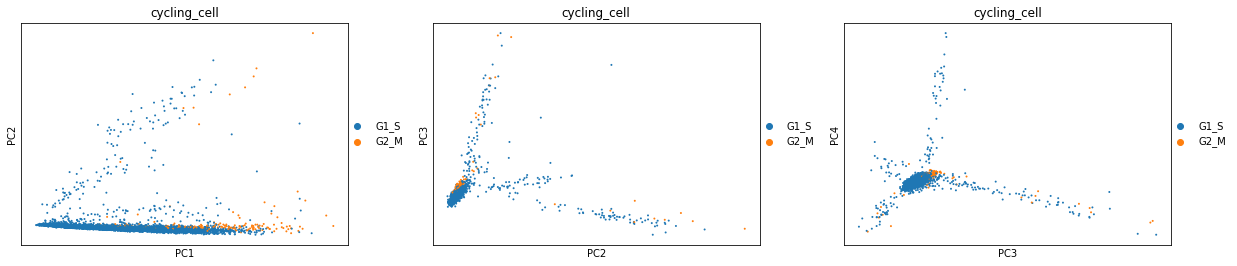

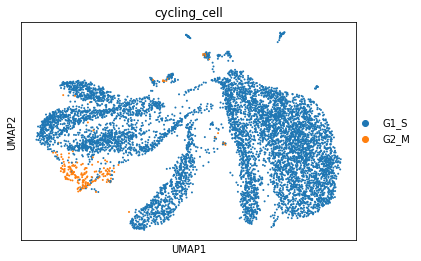

In [17]:
# append named_cluster
input_adata = recluster_0
anno_dict_0 = {'9':'dendritic',
               '10':'follicular_mel',
               '11':'mast',
               '12':'T_cell',
              }
for x in [x for x in set(input_adata.obs.louvain) \
          if x not in anno_dict_0.keys()]:
    anno_dict_0[x] = f'mel_{x}'
    
input_adata.obs['named_cluster'] = [anno_dict_0.get(x) for x in input_adata.obs.louvain]

# update cycling cell
input_adata.obs.named_cluster = [f'cyc_{x}' if y == 'G2_M' \
                                 else x \
                                 for x,y in zip(input_adata.obs.named_cluster,
                                                    input_adata.obs.cycling_cell)]
# plot cycling cell output
sc.pl.pca(input_adata, components=['1,2', '2,3','3,4'], color=['cycling_cell'])
sc.pl.umap(input_adata, color=['cycling_cell'], cmap='nipy_spectral')


###  recluster fibroblast-like cluster

... storing 'age_bin' as categorical
... storing 'plate' as categorical
... storing 'general_location' as categorical
... storing 'anatomical_location' as categorical
... storing 'race' as categorical
... storing 'sex' as categorical
... storing 'color' as categorical
... storing 'patient' as categorical
... storing 'cycling_cell' as categorical


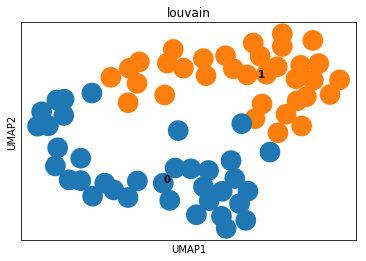

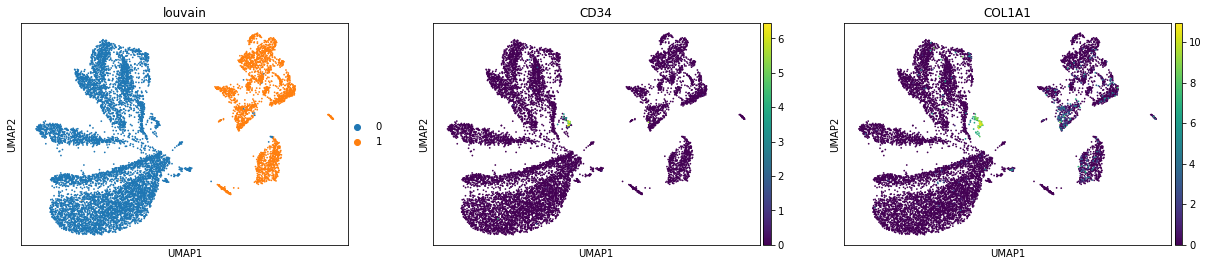

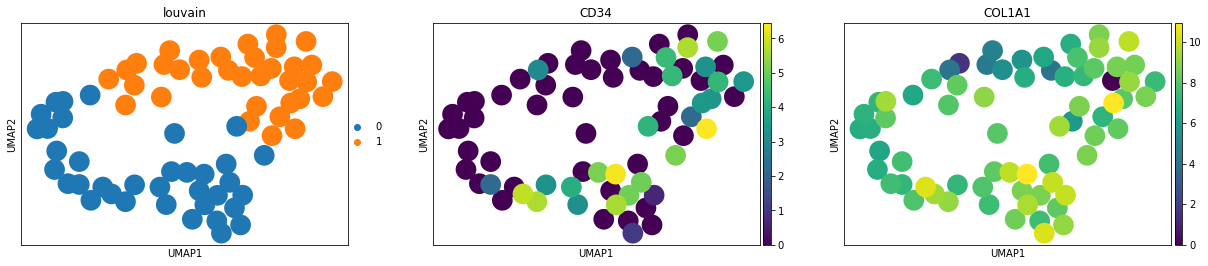

In [42]:
n_pcs = 10
coi = recluster_0[recluster_0.obs.louvain == '10'].obs.index.tolist()
raw_adata.obs['recluster'] = [x in coi for x in raw_adata.obs.index]
recluster_0_clust10 = raw_adata[raw_adata.obs['recluster'] == True]
recluster_0_clust10 = sc.pp.log1p(recluster_0_clust10, copy=True) # new
sc.pp.highly_variable_genes(recluster_0_clust10,min_mean=0.1,max_mean=10,min_disp=0.5) # new
sc.pp.scale(recluster_0_clust10) # new
sc.tl.pca(recluster_0_clust10, use_highly_variable = True, n_comps=n_pcs) # new
sc.pp.neighbors(recluster_0_clust10, n_pcs=n_pcs, n_neighbors=10) # new
sc.tl.umap(recluster_0_clust10, min_dist = 0.5)
sc.tl.louvain(recluster_0_clust10, resolution = 0.2)
sc.pl.umap(recluster_0_clust10, color=['louvain'], legend_loc='on data')
sc.pl.umap(full_adata, color=['louvain','CD34','COL1A1'])
sc.pl.umap(recluster_0_clust10, color=['louvain','CD34','COL1A1'])


## cluster_1

... storing 'age_bin' as categorical
... storing 'plate' as categorical
... storing 'general_location' as categorical
... storing 'anatomical_location' as categorical
... storing 'race' as categorical
... storing 'sex' as categorical
... storing 'color' as categorical
... storing 'patient' as categorical
... storing 'cycling_cell' as categorical


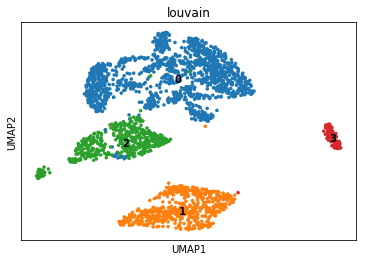

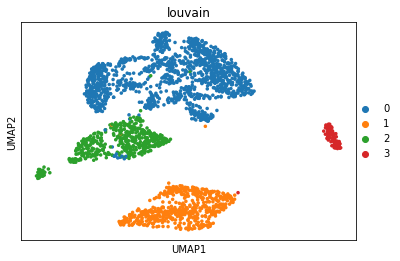

In [18]:
coi = full_adata[full_adata.obs.louvain == '1'].obs.index.tolist()
raw_adata.obs['recluster'] = [x in coi for x in raw_adata.obs.index]
recluster_1 = raw_adata[raw_adata.obs['recluster'] == True]
recluster_1 = sc.pp.log1p(recluster_1, copy=True) # new
sc.pp.highly_variable_genes(recluster_1,min_mean=0.1,max_mean=10,min_disp=0.5) # new
sc.pp.scale(recluster_1) # new
sc.tl.pca(recluster_1, use_highly_variable = True, n_comps=n_pcs) # new
sc.pp.neighbors(recluster_1, n_pcs=n_pcs, n_neighbors=35) # new
sc.tl.umap(recluster_1, min_dist = 0.5)
sc.tl.louvain(recluster_1, resolution = 0.1)
sc.pl.umap(recluster_1, color=['louvain'], legend_loc='on data')
sc.pl.umap(recluster_1, color=['louvain'])


... storing 'named_cluster' as categorical


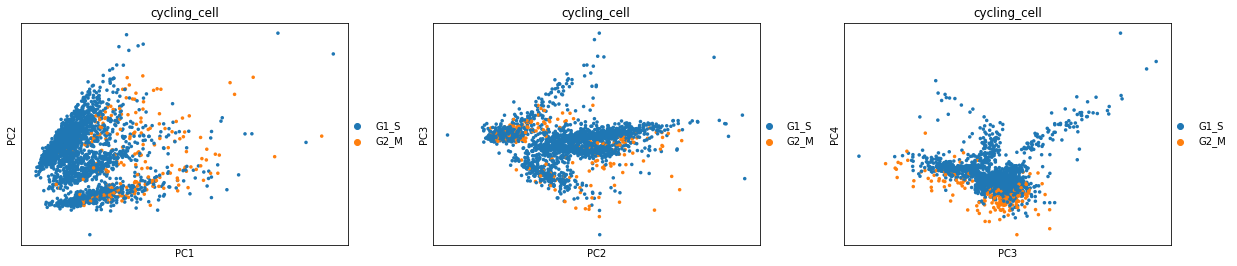

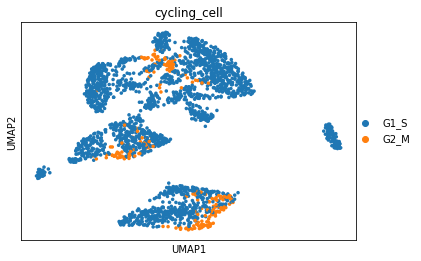

In [19]:
# append named_cluster
input_adata = recluster_1
anno_dict_1 = {'0':'krt_0',
               '1':'eccrine_0',
               '2':'krt_1',
               '3':'eccrine_1',
              }
full_adata.obs['named_cluster'] = [f'mel_{x}' if x not in anno_dict_1.keys() \
                                             else '{}'.format(anno_dict_0[x]) \
                                             for x in full_adata.obs.louvain]

input_adata.obs['named_cluster'] = [anno_dict_1.get(x) for x in input_adata.obs.louvain]

# update cycling cell
input_adata.obs.named_cluster = [f'cyc_{x}' if y == 'G2_M' \
                                 else x \
                                 for x,y in zip(input_adata.obs.named_cluster,
                                                    input_adata.obs.cycling_cell)]
# plot cycling cell output
sc.pl.pca(input_adata, components=['1,2', '2,3','3,4'], color=['cycling_cell'])
sc.pl.umap(input_adata, color=['cycling_cell'], cmap='nipy_spectral')


# annotations

## merge recluster annotations

... storing 'named_cluster' as categorical


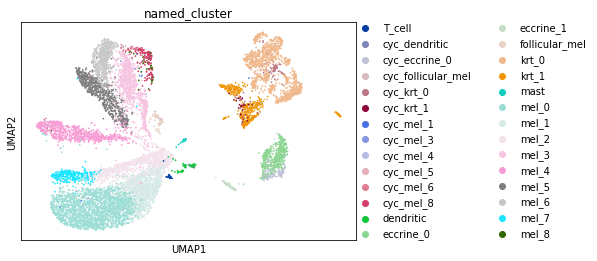

In [20]:
recluster_merge = recluster_1.obs.append(recluster_0.obs)
named_cluster_df = pd.merge(pd.DataFrame(full_adata.obs.index).rename(columns = {0:'index'}),
                          recluster_merge.loc[:,['named_cluster']].reset_index(),
                          'left',
                          'index')

full_adata.obs['named_cluster'] = named_cluster_df.named_cluster.tolist()
sc.pl.umap(full_adata, color = 'named_cluster')


## label updates

In [21]:
# update labels
dev_stage_order = ['fet','neo','adt']
subtypes_order = ['acral','foreskin','cutaneous']
acral_subtype_order = ['acral','not_acral']
foreskin_subtype_order = ['foreskin','not_foreskin']
dev_subtype_order = ['fet_acral','fet_cutaneous','neo_foreskin','adt_acral','adt_cutaneous']

for input_adata in [full_adata,recluster_0,recluster_1]:
    input_adata.obs['true_year'] = [float(x.split('WK')[0])/52 if len(x.split('WK')[0]) <= 3 else np.nan for x in input_adata.obs.patient]
    input_adata.obs['true_year'] = [y+(9/12) if np.isnan(x) else x for x,y in zip(input_adata.obs['true_year'], input_adata.obs['age']) ]

    input_adata.obs['dev_stage'] = ['adt' if x > 0 else 'neo' if x == 0 else 'fet' for x in input_adata.obs.age]
    input_adata.obs['subtypes'] = [x if x in ['acral','foreskin'] else 'cutaneous' for x in input_adata.obs.general_location]
    input_adata.obs['acral_subtype'] = [x if x == 'acral' else 'not_acral' for x in input_adata.obs['subtypes']]
    input_adata.obs['dev_subtype'] = [f'{x}_{y}' for x,y in zip(input_adata.obs.dev_stage, input_adata.obs.subtypes)]

    for i in ['dev_stage', 'subtypes', 'acral_subtype' ,'dev_subtype']:
        input_adata.obs[i] =  (input_adata
                                 .obs[i]
                                 .astype(str)
                               .astype(CategoricalDtype(eval(f'{i}_order'), ordered = True))
                              )  
        
    input_adata.obs['class_1'] = ['_'.join(x.split('_')[:-1]) if x.split('_')[-1].isdigit() \
                                      else '_'.join(x.split('_')) \
                                      for x in input_adata.obs['named_cluster']]
     

## DE genes as function of annotation

In [145]:
input_adata = full_adata
DE_df = pd.DataFrame()
type_order = ['mel',
                'cyc_mel',
                'follicular_mel',
                'cyc_follicular_mel',
                'krt',
                'cyc_krt',
                'eccrine',
                'cyc_eccrine',
                'dendritic',
                'cyc_dendritic',
                'mast',
                'T_cell',]
for x in tqdm.tqdm(type_order):
    tmpdf = pd.DataFrame()
    tmpdf['gene'] = fast_DE(input_adata, x,'class_1')
    tmpdf['class_1'] = x
    DE_df = DE_df.append(tmpdf)
    
gene_order = DE_df[~DE_df.gene.duplicated(keep='first')].gene.tolist()
    

100%|██████████| 12/12 [02:26<00:00, 12.06s/it]


## Marker gene citations

,gene,class_1
0,COL1A1,follicular_mel
1,COL3A1,follicular_mel
2,TWIST1,follicular_mel
3,COL1A2,follicular_mel
4,PRRX1,follicular_mel
5,TCF4,follicular_mel
6,COL6A2,follicular_mel
7,COL21A1,follicular_mel
8,COL5A2,follicular_mel
9,MEG3,follicular_mel


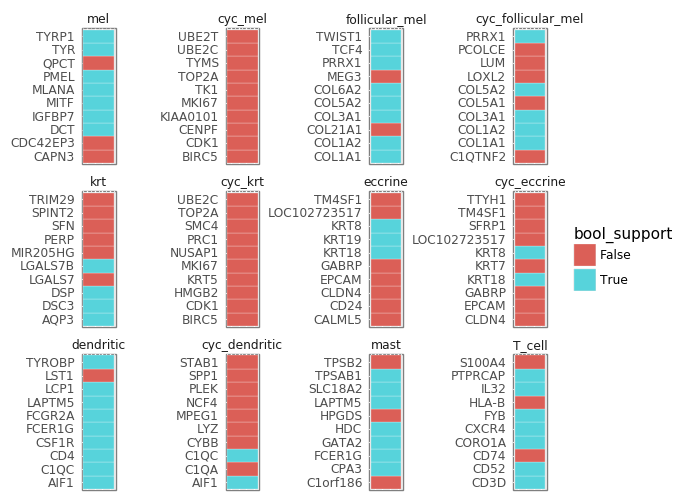

<ggplot: (-9223363299888475150)>


,class_1,cite
0,mel,10.1101/cshperspect.a017046
1,cyc_mel,10.1101/cshperspect.a017046
0,krt,10.1016/j.celrep.2018.09.006
1,cyc_krt,10.1016/j.celrep.2018.09.006
0,krt,10.1038/jid.2010.395
1,cyc_krt,10.1038/jid.2010.395
0,eccrine,10.1111/exd.12773
1,cyc_eccrine,10.1111/exd.12773
0,dendritic,10.1038/jid.2013.375
1,cyc_dendritic,10.1038/jid.2013.375


In [146]:
display(DE_df.query('class_1 == "follicular_mel"'))

cite_dict = {'10.1101/cshperspect.a017046':['TYR','TYRP1','DCT','MITF','IGFBP7','PMEL','MLANA'], # mel
             '10.1016/j.celrep.2018.09.006':['DSP','DSC3','LGALS7B'], # krt
             '10.1038/jid.2010.395':['AQP3'], # krt
             '10.1111/exd.12773':['KRT18','KRT19','KRT8'], # eccrine
             '10.1038/jid.2013.375':['FCGR2A','FCER1G','C1QC','LAPTM5','CSF1R','AIF1'], # dendritic
             '10.1182/blood-2013-02-483792':['LAPTM5','FCER1G','SLC18A2','GATA2'], # mast
             '10.1084/jem.20170910':['TPSAB1','CPA3','HDC','GATA2'], # mast
             '10.1038/s41598-017-01468-y':['TYROBP','CSF1R','LAPTM5','FCGR2A','FCER1G','LCP1','CD4','C1QC',
                                           'FYB','CORO1A','CXCR4','CD3D','CD52','PTPRCAP','IL32'], # dendritic / T cell
#              '10.1158/0008-5472.CAN-09-0783':['COL1A1','COL3A1','COL1A2',
#                                               'PRRX1','COL6A2','COL21A1','MEG3'] # nevus 
             '10.1371/journal.pgen.1008034':['TWIST1','PRRX1','COL1A1','TCF4',
                                             'COL3A1','COL1A2','COL6A2','COL5A2'] # HF
            }

cite_df = pd.DataFrame()
for key,value in cite_dict.items():
    df_slice = pd.DataFrame({'gene':value})
    df_slice['cite'] = key
    cite_df = cite_df.append(df_slice)    
DE_df = pd.merge(DE_df, cite_df, 'left', 'gene')

cite2class = {'10.1101/cshperspect.a017046':['mel','cyc_mel'],
              '10.1016/j.celrep.2018.09.006':['krt','cyc_krt'],
              '10.1038/jid.2010.395':['krt','cyc_krt'],
              '10.1111/exd.12773':['eccrine','cyc_eccrine'],
              '10.1038/jid.2013.375':['dendritic','cyc_dendritic'],
              '10.1038/s41598-017-01468-y':['dendritic','cyc_dendritic','T_cell','cyc_T_cell'],
              '10.1182/blood-2013-02-483792':['mast','cyc_mast'],
              '10.1084/jem.20170910':['mast','cyc_mast'],
              '10.1371/journal.pgen.1008034':['follicular_mel','cyc_follicular_mel']
             }

DE_df['support'] = [y in cite2class.get(x) if x is not np.nan else False for x,y in zip(DE_df.cite,DE_df.class_1)]
DE_df['class_1'] = (DE_df['class_1']
                      .astype(str)
                      .astype(CategoricalDtype(type_order, ordered=True))
                     )
plot_df = pd.DataFrame(DE_df.groupby(['class_1','gene'])['support'].sum()).reset_index()
plot_df['bool_support'] = [x > 0 for x in plot_df['support']]
plot_df['xvar'] = 0
plot_df['class_1'] = (plot_df['class_1']
                      .astype(str)
                      .astype(CategoricalDtype(type_order, ordered=True))
                     )

plotnine.options.figure_size = (6,6)
plot = (ggplot(plot_df)
        + theme_bw()
        + theme(panel_spacing_x = 1.1,
                axis_text_x = element_blank(),
                strip_background = element_blank(),
                axis_ticks = element_blank()
               )
        + geom_tile(aes('xvar','gene', fill = 'bool_support'), color = 'white')
        + facet_wrap('~class_1', scales = 'free')
        + labs(x = '', y = '')
#         + scale_fill_manual(values = ['red','green','blue','orange','purple','yellow','pink','brown','grey','white'])
       )
print(plot)

# table of cell annotations and citations
cite2class_df = pd.DataFrame()
for key,value in cite2class.items():
    df_slice = pd.DataFrame({'class_1':value})
    df_slice['cite'] = key
    cite2class_df = cite2class_df.append(df_slice)
cite2class_df['class_1'] = (cite2class_df['class_1']
                      .astype(str)
                      .astype(CategoricalDtype(type_order, ordered=True))
                     )
display(cite2class_df.dropna())


# save

In [148]:
# pickle adatas
for objname in ['raw_adata','full_adata',
                'recluster_0','recluster_1', 'DE_df']:
    pickle.dump(eval(objname), open( f"{wkdir}/{objname}.p", "wb" ) )
    syscmd = f'aws s3 cp {wkdir}/{objname}.p s3://{s3dir}/'
    subprocess.run(syscmd.split(' '))